In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import os
import random
from torch.autograd import Variable
import copy
from torch import nn, optim
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import csv
import time
import math

In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
fix_seed(SEED)

In [3]:
class Argments():
  def __init__(self):
    self.batch_size = 40
    self.test_batch = 1000
    self.global_epochs = 500
    self.local_epochs = 2
    self.lr = None
    self.momentum = 0.9
    self.weight_decay = 10**-4.0
    self.clip = 20.0
    self.partience = 500
    self.worker_num = 20
    self.sample_num = 20
    self.cluster_num = 2
    self.unlabeleddata_size = 1000
    self.device = torch.device('cuda:0'if torch.cuda.is_available() else'cpu')
    self.criterion = nn.CrossEntropyLoss()
    
    self.alpha_label = 0.5
    self.alpha_size = 10

args = Argments()

In [4]:
# Tuned value
lr = 2

In [6]:
lr_list = []
lr_list.append(10**-3.0)
lr_list.append(10**-2.5)
lr_list.append(10**-2.0)
lr_list.append(10**-1.5)
lr_list.append(10**-1.0)
lr_list.append(10**-0.5)
lr_list.append(10**0.0)
lr_list.append(10**0.5)

args.lr = lr_list[lr]

In [9]:
class LocalDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.data = []
        self.label = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]
        if self.transform:
            out_data = self.transform(out_data)
        return out_data, out_label
    
class DatasetFromSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
class GlobalDataset(torch.utils.data.Dataset):
  def __init__(self,federated_dataset,transform=None):
    self.transform = transform
    self.data = []
    self.label = []
    for dataset in federated_dataset:
      for (data,label) in dataset:
        self.data.append(data)
        self.label.append(label)

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = self.label[idx]
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

class UnlabeledDataset(torch.utils.data.Dataset):
  def __init__(self,transform=None):
    self.transform = transform
    self.data = []
    self.target = None

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = 'unlabeled'
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

In [10]:
def get_dataset(Centralized=False,unlabeled_data=False):
    
    transform_train = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomCrop(32, padding=2),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])
    transform_test = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])

    # download train data
    all_trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
    #trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

    # download test data
    all_testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True)
    #testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

    
    ## get unlabeled dataset
    if unlabeled_data:
        unlabeled_dataset = UnlabeledDataset(transform_test)
        idx = sorted(random.sample(range(len(all_trainset)),args.unlabeleddata_size))
        unlabeled_dataset.data = np.array([all_trainset.data[i]  for i in idx])
        all_trainset.data = np.delete(all_trainset.data,idx,0)
        all_trainset.targets = np.delete(all_trainset.targets,idx,0)
    all_train_data = np.array(all_trainset.data)
    all_train_label = np.array(all_trainset.targets)
    all_test_data = np.array(all_testset.data)
    all_test_label = np.array(all_testset.targets)
    print('Train:{} Test:{}'.format(len(all_train_data),len(all_test_data)))


    ## Data size heterogeneity
    data_proportions = np.random.dirichlet(np.repeat(args.alpha_size, args.worker_num))
    train_data_proportions = np.array([0 for _ in range(args.worker_num)])
    test_data_proportions = np.array([0 for _ in range(args.worker_num)])
    for i in range(len(data_proportions)):
        if i==(len(data_proportions)-1):
            train_data_proportions = train_data_proportions.astype('int64')
            test_data_proportions = test_data_proportions.astype('int64')
            train_data_proportions[-1] = len(all_train_data) - np.sum(train_data_proportions[:-1])
            test_data_proportions[-1] = len(all_test_data) - np.sum(test_data_proportions[:-1])
        else:
            train_data_proportions[i] = (data_proportions[i] * len(all_train_data))
            test_data_proportions[i] = (data_proportions[i] * len(all_test_data))
    min_size = 0
    K = 10

    '''
    label_list = np.arange(10)
    np.random.shuffle(label_list)
    '''
    label_list = list(range(K))


    ## Data distribution heterogeneity
    while min_size<10:
        idx_train_batch = [[] for _ in range(args.worker_num)]
        idx_test_batch = [[] for _ in range(args.worker_num)]
        for k in label_list:
            proportions_train = np.random.dirichlet(np.repeat(args.alpha_label, args.worker_num))
            proportions_test = copy.deepcopy(proportions_train)
            idx_k_train = np.where(all_train_label == k)[0]
            idx_k_test = np.where(all_test_label == k)[0]
            np.random.shuffle(idx_k_train)
            np.random.shuffle(idx_k_test)
            ## Balance (train)
            proportions_train = np.array([p*(len(idx_j)<train_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_train,idx_train_batch))])
            proportions_train = proportions_train/proportions_train.sum()
            proportions_train = (np.cumsum(proportions_train)*len(idx_k_train)).astype(int)[:-1]
            idx_train_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_train_batch,np.split(idx_k_train,proportions_train))]

            ## Balance (test)
            proportions_test = np.array([p*(len(idx_j)<test_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_test,idx_test_batch))])
            proportions_test = proportions_test/proportions_test.sum()
            proportions_test = (np.cumsum(proportions_test)*len(idx_k_test)).astype(int)[:-1]
            idx_test_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_test_batch,np.split(idx_k_test,proportions_test))]

            min_size = min([len(idx_j) for idx_j in idx_train_batch])

    federated_trainset = []
    federated_testset = []
    for i in range(args.worker_num):
        ## create trainset
        data = [all_train_data[idx] for idx in idx_train_batch[i]]
        label = [all_train_label[idx] for idx in idx_train_batch[i]]
        federated_trainset.append(LocalDataset())
        federated_trainset[-1].data = data
        federated_trainset[-1].label = label

        ## create testset
        data = [all_test_data[idx] for idx in idx_test_batch[i]]
        label = [all_test_label[idx] for idx in idx_test_batch[i]]
        federated_testset.append(LocalDataset())
        federated_testset[-1].data = data
        federated_testset[-1].label = label

        
    ## split trainset
    federated_valset = [None]*args.worker_num
    for i in range(args.worker_num):
        n_samples = len(federated_trainset[i])
        if n_samples==1:
            train_subset = federated_trainset[i]
            val_subset = copy.deepcopy(federated_trainset[i])
        else:
            train_size = int(len(federated_trainset[i]) * 0.8) 
            val_size = n_samples - train_size 
            train_subset,val_subset = torch.utils.data.random_split(federated_trainset[i], [train_size, val_size])

        federated_trainset[i] = DatasetFromSubset(train_subset)
        federated_valset[i] = DatasetFromSubset(val_subset)

    ## show data distribution
    H = 4
    W = 5
    fig, axs = plt.subplots(H, W, figsize=(20, 5))
    x = np.arange(1,11)
    for i, (trainset,valset,testset) in enumerate(zip(federated_trainset,federated_valset,federated_testset)):
        bottom = [0]*10
        count = [0]*10
        for _,label in trainset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in valset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in testset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        #axs[int(i/W), i%W].title("worker{}".format(i+1), fontsize=12, color = "green")

    plt.show()

    ## get global dataset
    if Centralized:
        global_trainset = GlobalDataset(federated_trainset)
        global_valset = GlobalDataset(federated_valset)
        global_testset =  GlobalDataset(federated_testset)
        
        #show_cifer(global_trainset.data,global_testset.label, cifar10_labels)

        global_trainset.transform = transform_train
        global_valset.transform = transform_test
        global_testset.transform = transform_test

        global_trainloader = torch.utils.data.DataLoader(global_trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
        global_valloader = torch.utils.data.DataLoader(global_valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
        global_testloader = torch.utils.data.DataLoader(global_testset,batch_size=args.test_batch,shuffle=False,num_workers=2)

    ## set transform
    for i in range(args.worker_num):
        federated_trainset[i].transform = transform_train
        federated_valset[i].transform = transform_test
        federated_testset[i].transform = transform_test
    
    if Centralized and unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader,unlabeled_dataset
    if Centralized:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader
    elif unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,unlabeled_dataset
    else:
        return federated_trainset,federated_valset,federated_testset

Files already downloaded and verified
Files already downloaded and verified
Train:49000 Test:10000


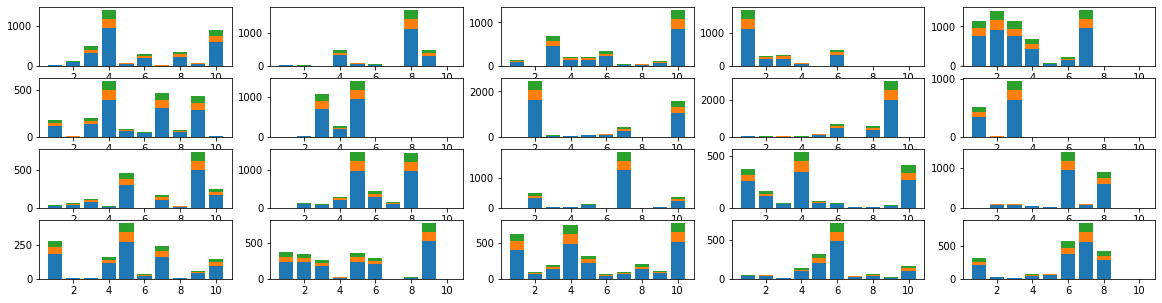

In [11]:
federated_trainset,federated_valset,federated_testset,unlabeled_dataset = get_dataset(unlabeled_data=True)

In [12]:
total = [0,0,0]
for i in range(args.worker_num):
    total[0]+=len(federated_trainset[i])
    total[1]+=len(federated_valset[i])
    total[2]+=len(federated_testset[i])
print(total)

[39191, 9809, 10000]


In [14]:
class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            #print("in_channels: {}, v: {}".format(in_channels, v))
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


class VGGConvBlocks(nn.Module):
    '''
    VGG containers that only contains the conv layers 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

class VGGContainer(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, input_dim, hidden_dims, num_classes=10):
        super(VGGContainer, self).__init__()
        self.features = features
        # note: we hard coded here a bit by assuming we only have two hidden layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(True),
            nn.Linear(hidden_dims[1], num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def matched_vgg11(matched_shapes):
    # [(67, 27), (67,), (132, 603), (132,), (260, 1188), (260,), (261, 2340), (261,), (516, 2349), (516,), (517, 4644), (517,), 
    # (516, 4653), (516,), (516, 4644), (516,), (516, 515), (515,), (515, 515), (515,), (515, 10), (10,)]
    processed_matched_shape = [matched_shapes[0][0], 
                                'M', 
                                matched_shapes[2][0], 
                                'M', 
                                matched_shapes[4][0], 
                                matched_shapes[6][0], 
                                'M', 
                                matched_shapes[8][0], 
                                matched_shapes[10][0], 
                                'M', 
                                matched_shapes[12][0], 
                                matched_shapes[14][0], 
                                'M']
    return VGGContainer(make_layers(processed_matched_shape), input_dim=matched_shapes[16][0], 
            hidden_dims=[matched_shapes[16][1], matched_shapes[18][1]], num_classes=10)


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn(num_classes=10):
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True), num_classes=num_classes)


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [15]:
class Server():
  def __init__(self):
    self.models = []
    for i in range(args.cluster_num):
      self.models.append(vgg13())

  def model_initialize(self,workers):
    sample_worker = self.sample_worker(workers)
    self.send_models(sample_worker)
    for i,worker in enumerate(sample_worker):
      worker.cluster = i%args.cluster_num
      _ = worker.local_train()
    self.aggregate_models(sample_worker)

  def create_worker(self,federated_trainset,federated_valset,federated_testset):
    workers = []
    for i in range(args.worker_num):
      workers.append(Worker(federated_trainset[i],federated_valset[i],federated_testset[i]))
    return workers

  def sample_worker(self,workers):
    sample_worker = []
    sample_worker_num = random.sample(range(args.worker_num),args.sample_num)
    for i in sample_worker_num:
      sample_worker.append(workers[i])
    return sample_worker


  def send_models(self,workers):
    nums = 0
    for worker in workers:
      nums += worker.train_data_num

    for worker in workers:
      worker.aggregation_weight = 1.0*worker.train_data_num/nums
      worker.models = copy.deepcopy(self.models)
      for i in range(args.cluster_num):
        worker.models[i] = worker.models[i].to(args.device)

  def aggregate_models(self,workers):
    new_params = []
    for i in range(args.cluster_num):   
      new_params.append(OrderedDict())
    total_num = [0]*args.cluster_num
    for worker in workers:
      total_num[worker.cluster] += worker.train_data_num
    count = [0]*args.cluster_num    
    for worker in workers:
      worker_state = worker.models[worker.cluster].state_dict()
      for key in worker_state.keys():
        if count[worker.cluster]==0:
          new_params[worker.cluster][key] = 1.0*worker_state[key]*worker.train_data_num/total_num[worker.cluster]
        else:
          new_params[worker.cluster][key] += 1.0*worker_state[key]*worker.train_data_num/total_num[worker.cluster]
      count[worker.cluster] += 1
      for i in range(args.cluster_num):
        worker.models[i] = worker.models[i].to('cpu')
      del worker.models

    for i in range(args.cluster_num):
      if total_num[i]!=0:
        self.models[i].load_state_dict(new_params[i])

In [16]:
class Worker():
  def __init__(self,trainset,valset,testset):
    self.trainloader = torch.utils.data.DataLoader(trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
    self.valloader = torch.utils.data.DataLoader(valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    self.testloader = torch.utils.data.DataLoader(testset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    self.models = None
    self.cluster = None
    self.train_data_num = len(trainset)
    self.test_data_num = len(testset)
    self.aggregation_weight = None

  def local_train(self):
    acc_train,loss_train = train(self.models[self.cluster],args.criterion,self.trainloader,args.local_epochs)
    acc_valid,loss_valid = test(self.models[self.cluster],args.criterion,self.valloader)
    return acc_train,loss_train,acc_valid,loss_valid

  def clustering(self,models):
    for i in range(args.cluster_num):
      if i==0:
        cluster = 0
        _,loss = test(models[i],args.criterion,self.trainloader)
      else:
        _,tmp = test(models[i],args.criterion,self.trainloader)
        if tmp<loss:
          cluster = i
    self.cluster = cluster
    

In [17]:
def train(model,criterion,trainloader,epochs):
  optimizer = optim.SGD(model.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    count = 0
    for (data,labels) in trainloader:
      data,labels = Variable(data),Variable(labels)
      data,labels = data.to(args.device),labels.to(args.device)
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs,labels)
      running_loss += loss.item()
      predicted = torch.argmax(outputs,dim=1)
      correct += (predicted==labels).sum().item()
      count += len(labels)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
      optimizer.step()

  return 100.0*correct/count,running_loss/len(trainloader)

In [18]:
def test(model,criterion,testloader):
  model.eval()
  running_loss = 0.0
  correct = 0
  count = 0
  for (data,labels) in testloader:
    data,labels = data.to(args.device),labels.to(args.device)
    outputs = model(data)
    running_loss += criterion(outputs,labels).item()
    predicted = torch.argmax(outputs,dim=1)
    correct += (predicted==labels).sum().item()
    count += len(labels)

  accuracy = 100.0*correct/count
  loss = running_loss/len(testloader)


  return accuracy,loss

In [19]:
class Early_Stopping():
  def __init__(self,partience):
    self.step = 0
    self.loss = float('inf')
    self.partience = partience

  def validate(self,loss):
    if self.loss<loss:
      self.step += 1
      if self.step>self.partience:
        return True
    else:
      self.step = 0
      self.loss = loss

    return False

In [20]:
server = Server()
workers = server.create_worker(federated_trainset,federated_valset,federated_testset)
acc_train = []
loss_train = []
acc_valid = []
loss_valid = []

early_stopping = Early_Stopping(args.partience)

start = time.time()

for epoch in range(args.global_epochs):
  sample_worker = server.sample_worker(workers)
  server.send_models(sample_worker)

  acc_train_avg = 0.0
  loss_train_avg = 0.0
  acc_valid_avg = 0.0
  loss_valid_avg = 0.0
  for worker in sample_worker:
    worker.clustering(worker.models)
    acc_train_tmp,loss_train_tmp,acc_valid_tmp,loss_valid_tmp = worker.local_train()
    acc_train_avg += acc_train_tmp/len(sample_worker)
    loss_train_avg += loss_train_tmp/len(sample_worker)
    acc_valid_avg += acc_valid_tmp/len(sample_worker)
    loss_valid_avg += loss_valid_tmp/len(sample_worker)
  server.aggregate_models(sample_worker)
  '''
  for i in range(args.cluster_num):
    server.models[i].to(args.device)
  for worker in workers:
    worker.clustering(server.models)
    acc_valid_tmp,loss_valid_tmp = test(server.models[worker.cluster],args.criterion,worker.valloader)
    acc_valid_avg += acc_valid_tmp/len(workers)
    loss_valid_avg += loss_valid_tmp/len(workers)
  for i in range(args.cluster_num):
    server.models[i].to('cpu')
  '''
  print('Epoch{}  loss:{}  accuracy:{}'.format(epoch+1,loss_valid_avg,acc_valid_avg))
  acc_train.append(acc_train_avg)
  loss_train.append(loss_train_avg)
  acc_valid.append(acc_valid_avg)
  loss_valid.append(loss_valid_avg)

  if early_stopping.validate(loss_valid_avg):
    print('Early Stop')
    break
    
end = time.time()

Epoch1  loss:1.6331642270088194  accuracy:42.33116331868391
Epoch2  loss:1.4816619038581846  accuracy:43.51094328763154
Epoch3  loss:1.4736214756965638  accuracy:43.565912313447875
Epoch4  loss:1.4662814199924468  accuracy:43.72183208872053
Epoch5  loss:1.457570168375969  accuracy:44.496378493277184
Epoch6  loss:1.4506900578737256  accuracy:44.56562942362666
Epoch7  loss:1.4407233834266662  accuracy:44.793657719148754
Epoch8  loss:1.427360486984253  accuracy:45.82021025622126
Epoch9  loss:1.3768667608499527  accuracy:49.525259271876045
Epoch10  loss:1.3237205862998962  accuracy:52.84124336401177
Epoch11  loss:1.280868783593178  accuracy:53.25233899650368
Epoch12  loss:1.2343385905027389  accuracy:55.080089826621084
Epoch13  loss:1.2124754965305329  accuracy:55.16439063563963
Epoch14  loss:1.19622410684824  accuracy:55.83482821965234
Epoch15  loss:1.1726156622171404  accuracy:56.193387986893434
Epoch16  loss:1.1595454186201093  accuracy:57.22596348516061
Epoch17  loss:1.1445778012275696

Epoch136  loss:0.5884734809398651  accuracy:80.8221556450566
Epoch137  loss:0.5802225477993488  accuracy:81.28359682161269
Epoch138  loss:0.5939632698893548  accuracy:81.04660060860384
Epoch139  loss:0.57257479429245  accuracy:81.29449173175713
Epoch140  loss:0.5748556330800056  accuracy:81.65947847713939
Epoch141  loss:0.5752149093896151  accuracy:81.35573035274916
Epoch142  loss:0.5764927595853805  accuracy:81.09862975580285
Epoch143  loss:0.5902578480541705  accuracy:81.60805280672724
Epoch144  loss:0.5694693230092527  accuracy:81.7576216642319
Epoch145  loss:0.5833124287426471  accuracy:81.41436373471387
Epoch146  loss:0.5920983657240868  accuracy:81.00927216084447
Epoch147  loss:0.5535596281290055  accuracy:82.32819708076849
Epoch148  loss:0.5478063613176346  accuracy:82.44941939937583
Epoch149  loss:0.5824028037488461  accuracy:81.55604973674795
Epoch150  loss:0.5827917911112309  accuracy:81.78315465292971
Epoch151  loss:0.5813098527491092  accuracy:81.93508105701986
Epoch152  lo

Epoch269  loss:0.6419994605847023  accuracy:84.97905814564194
Epoch270  loss:0.6369643399710185  accuracy:85.20189428973693
Epoch271  loss:0.6583644454090972  accuracy:84.52416643091286
Epoch272  loss:0.6684408286004327  accuracy:85.24197084215574
Epoch273  loss:0.65898678660742  accuracy:84.75865701562776
Epoch274  loss:0.6694331582995801  accuracy:84.9289419447007
Epoch275  loss:0.6713259525597095  accuracy:84.59148512321195
Epoch276  loss:0.6828881023022405  accuracy:84.40438144196769
Epoch277  loss:0.6756092472023738  accuracy:84.82097797766929
Epoch278  loss:0.7032632730867363  accuracy:84.5841534784511
Epoch279  loss:0.6692429616039589  accuracy:85.50000389235609
Epoch280  loss:0.6643249662862218  accuracy:85.50739795117644
Epoch281  loss:0.6725849533624569  accuracy:84.55357820686189
Epoch282  loss:0.6942603247938677  accuracy:85.37015746866587
Epoch283  loss:0.7113106732431335  accuracy:84.34313373310056
Epoch284  loss:0.6919634216355918  accuracy:84.70892344887721
Epoch285  lo

Epoch402  loss:0.8552299036945441  accuracy:85.46145394395712
Epoch403  loss:0.8037350952625191  accuracy:85.97718827448114
Epoch404  loss:0.8044758421368895  accuracy:86.0054022269916
Epoch405  loss:0.8186604149581627  accuracy:85.611803109412
Epoch406  loss:0.7876132287083522  accuracy:86.1439663314548
Epoch407  loss:0.8064191773533818  accuracy:85.6012057890666
Epoch408  loss:0.8091803960502149  accuracy:85.61897089033745
Epoch409  loss:0.8364233888685698  accuracy:85.83109860616372
Epoch410  loss:0.7847022613917033  accuracy:86.21406183371408
Epoch411  loss:0.809412495791912  accuracy:85.87296515600352
Epoch412  loss:0.8159265622496593  accuracy:85.29140713119358
Epoch413  loss:0.8037915830529528  accuracy:85.89519970339435
Epoch414  loss:0.8766627855598927  accuracy:85.01212611309859
Epoch415  loss:0.816124400496466  accuracy:85.87566418460936
Epoch416  loss:0.8644996166226692  accuracy:85.7750042476255
Epoch417  loss:0.8172097727656336  accuracy:85.78374222306411
Epoch418  loss:0

In [22]:
acc_test = []
loss_test = []

for i in range(args.cluster_num):
  server.models[i].to(args.device)

nums = 0
for worker in workers:
  nums += worker.test_data_num

start = time.time()

for i,worker in enumerate(workers):
  worker.aggregation_weight = 1.0*worker.test_data_num/nums
  worker.clustering(server.models)
  acc_tmp,loss_tmp = test(server.models[worker.cluster],args.criterion,worker.testloader)
  acc_test.append(acc_tmp)
  loss_test.append(loss_tmp)
  print('Worker{} accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))

end = time.time()

acc_test_avg = sum(acc_test)/len(acc_test)
loss_test_avg = sum(loss_test)/len(loss_test)
print('Test  loss:{}  accuracy:{}'.format(loss_test_avg,acc_test_avg))

Worker1 accuracy:76.036866359447  loss:1.3084914684295654
Worker2 accuracy:79.71311475409836  loss:1.4983618259429932
Worker3 accuracy:82.28571428571429  loss:1.0096631050109863
Worker4 accuracy:82.14285714285714  loss:0.9509595632553101
Worker5 accuracy:85.07317073170732  loss:0.6511935293674469
Worker6 accuracy:77.15877437325905  loss:1.5021748542785645
Worker7 accuracy:77.47368421052632  loss:1.241562843322754
Worker8 accuracy:87.9415347137637  loss:0.6782227754592896
Worker9 accuracy:89.04458598726114  loss:0.7916321754455566
Worker10 accuracy:79.76190476190476  loss:0.9706471562385559
Worker11 accuracy:77.77777777777777  loss:1.1192662715911865
Worker12 accuracy:74.96402877697842  loss:1.7317689657211304
Worker13 accuracy:90.0  loss:0.5182749032974243
Worker14 accuracy:78.96551724137932  loss:1.2932301759719849
Worker15 accuracy:78.43137254901961  loss:1.4323174953460693
Worker16 accuracy:79.91266375545851  loss:1.2022693157196045
Worker17 accuracy:75.23584905660377  loss:2.115704

In [24]:
acc_tune_test = []
loss_tune_test = []
acc_tune_valid = []
loss_tune_valid = []

start = time.time()

for i,worker in enumerate(workers):
    worker.models = copy.deepcopy(server.models)
    worker.models[worker.cluster] = worker.models[worker.cluster].to(args.device)
    _,_,acc_tmp,loss_tmp = worker.local_train()
    acc_tune_valid.append(acc_tmp)
    loss_tune_valid.append(loss_tmp)
    print('Worker{} Valid accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))
    
    acc_tmp,loss_tmp = test(worker.models[worker.cluster],args.criterion,worker.testloader)
    acc_tune_test.append(acc_tmp)
    loss_tune_test.append(loss_tmp)
    print('Worker{} Test accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))
    for i in range(args.cluster_num):
        worker.models[i] = worker.models[i].to('cpu')
    del worker.models

end = time.time()

acc_valid_avg = sum(acc_tune_valid)/len(acc_tune_valid)
loss_valid_avg = sum(loss_tune_valid)/len(loss_tune_valid)
print('Validation(tune)  loss:{}  accuracy:{}'.format(loss_valid_avg,acc_valid_avg))
acc_test_avg = sum(acc_tune_test)/len(acc_tune_test)
loss_test_avg = sum(loss_tune_test)/len(loss_tune_test)
print('Test(tune)  loss:{}  accuracy:{}'.format(loss_test_avg,acc_test_avg))

Worker1 Valid accuracy:83.15132605304213  loss:1.4889482259750366
Worker1 Test accuracy:84.17818740399386  loss:1.2197999954223633
Worker2 Valid accuracy:86.92946058091286  loss:1.005157232284546
Worker2 Test accuracy:87.90983606557377  loss:0.9609335064888
Worker3 Valid accuracy:83.203125  loss:0.9617648720741272
Worker3 Test accuracy:85.14285714285714  loss:0.9634528756141663
Worker4 Valid accuracy:89.0909090909091  loss:0.6090174317359924
Worker4 Test accuracy:88.88888888888889  loss:0.6335127949714661
Worker5 Valid accuracy:84.9601593625498  loss:0.5409492254257202
Worker5 Test accuracy:87.60975609756098  loss:0.5938011556863785
Worker6 Valid accuracy:80.39772727272727  loss:1.2702502012252808
Worker6 Test accuracy:79.66573816155989  loss:1.3863167762756348
Worker7 Valid accuracy:86.7237687366167  loss:0.8496512770652771
Worker7 Test accuracy:86.73684210526316  loss:0.8544411063194275
Worker8 Valid accuracy:91.56327543424318  loss:0.5470044016838074
Worker8 Test accuracy:92.6918392

In [26]:
cluster = [0]*args.cluster_num
for worker in workers:
  cluster[worker.cluster] += 1

print(cluster)

[5, 15]
